In [32]:
import numpy as np
import pandas as pd
import emcee 
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn import tree
from sklearn.model_selection import cross_val_score
import re

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import corner

In [239]:
DF = pd.read_table('simulations.dat', sep='\t')
DF['age'] = DF['age'] / 10**9
DF.head()

,id,M,Y,Z,alpha,diffusion,age,beta,Teff,L,...,r01_44,nu_3_8,nu_2_9,nu_3_44,nu_2_8,nu_1_45,r02_45,r13_45,r10_44,nu_1_9
0,20001,0.776883,0.285652,0.007474,0.720276,1,8.398173,-0.025153,5022.223586,0.546163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20002,0.811883,0.225652,0.015805,2.220276,1,6.198423,0.024847,4830.176155,0.270065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20003,0.741883,0.265652,0.003534,1.220276,1,10.597923,-0.075153,5530.540668,0.533502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20004,0.759383,0.235652,0.005139,1.970276,1,5.098548,-0.050153,5324.783056,0.351822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20007,0.724383,0.295652,0.010868,1.470276,1,7.298298,0.099847,5081.494960,0.336307,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [240]:
DF.shape

(27520, 305)

In [241]:
KIC = pd.read_table('../regression/perturb/bigG/7970740_perturb.dat')
KIC = KIC.drop(['Dnu0', 'dnu02', 'r02', 'r01', 'r10'], axis=1)
KIC = KIC.drop([i for i in KIC.columns 
    if re.search('nu_|r01_', i)], axis=1)
KIC_columns = KIC.columns.values
KIC_columns[1] = 'Fe_H'
KIC.columns = KIC_columns
KIC.head()

,Teff,Fe_H,r02_17,r02_18,r02_19,r02_20,r02_21,r02_22,r02_23,r02_24,...,r10_19,r10_20,r10_21,r10_22,r10_23,r10_24,r10_25,r10_26,r10_27,r10_28
0,5309.000000,-0.540000,0.063186,0.056338,0.054542,0.055206,0.049283,0.049298,0.052405,0.036912,...,0.015446,0.015210,0.014888,0.014634,0.014336,0.015857,0.014204,0.010339,0.007882,0.019809
1,5406.247480,-0.572623,0.064753,0.057509,0.054785,0.056270,0.049662,0.048558,0.050471,0.036498,...,0.015442,0.015770,0.014949,0.014335,0.014835,0.015585,0.014184,0.010739,0.002031,0.019091
2,5291.495691,-0.513386,0.062448,0.055563,0.054344,0.056732,0.049226,0.049792,0.050888,0.037943,...,0.015297,0.015168,0.014699,0.014357,0.013725,0.016313,0.014485,0.009978,0.005982,0.018987
3,5326.634508,-0.440346,0.069188,0.052609,0.054532,0.053740,0.048868,0.048610,0.054871,0.034841,...,0.015781,0.015021,0.014749,0.014997,0.013261,0.014480,0.014027,0.011441,0.010553,0.019370
4,5274.490584,-0.492826,0.063603,0.056196,0.056307,0.054735,0.048241,0.047175,0.052728,0.041067,...,0.015662,0.015422,0.015030,0.014258,0.013659,0.016100,0.015520,0.011253,0.012393,0.028254


In [242]:
y_star = KIC.iloc[0]
y_star

Teff      5309.000000
Fe_H        -0.540000
r02_17       0.063186
r02_18       0.056338
r02_19       0.054542
r02_20       0.055206
r02_21       0.049283
r02_22       0.049298
r02_23       0.052405
r02_24       0.036912
r02_25       0.035124
r02_26       0.028170
r02_27       0.014598
r02_28       0.034549
r02_29       0.030393
r10_16       0.020654
r10_17       0.019698
r10_18       0.018950
r10_19       0.015446
r10_20       0.015210
r10_21       0.014888
r10_22       0.014634
r10_23       0.014336
r10_24       0.015857
r10_25       0.014204
r10_26       0.010339
r10_27       0.007882
r10_28       0.019809
Name: 0, dtype: float64

[7.7000000000e+01 1.0000000000e-01 3.9029146453e-03 2.1725166110e-03 1.4763450735e-03
 1.0333801995e-03 1.1141153559e-03 9.9657954298e-04 1.5794116586e-03 3.0378212737e-03
 4.6829660573e-03 6.9970515064e-03 5.1684757992e-03 7.7142395021e-03 8.8689859465e-03
 8.2823371490e-04 5.6268399444e-04 4.4734607701e-04 4.0459075105e-04 4.5440933645e-04
 5.3669735521e-04 5.7708904568e-04 8.9493725612e-04 1.2624834117e-03 1.7150952707e-03
 2.5820145538e-03 3.9392679640e-03 5.1059887744e-03]


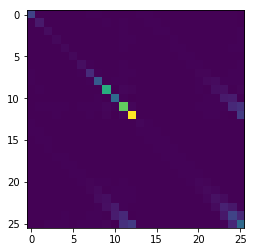

In [243]:
Sigma = np.cov(KIC.iloc[:,2:].T)
Sigma = np.vstack([np.zeros(Sigma.shape[0]), np.zeros(Sigma.shape[0]), Sigma])
Sigma = np.insert(Sigma, 0, np.zeros(Sigma.shape[0]), axis=1)
Sigma = np.insert(Sigma, 0, np.zeros(Sigma.shape[0]), axis=1)
Sigma[0,0] = 77**2
Sigma[1,1] = 0.1**2

np.set_printoptions(precision=10)
print(np.sqrt(np.diag(Sigma)))

plt.imshow(Sigma[2:,2:], interpolation='nearest')
plt.show()

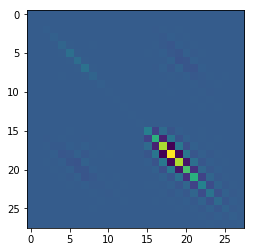

In [244]:
Sigma_inv = np.linalg.inv(Sigma)
Sigma_inv

plt.imshow(Sigma_inv, interpolation='nearest')
plt.show()

In [245]:
Sigma_inv.shape

(28, 28)

In [246]:
# train a forest to learn Teff, FeH, nu_max, Dnu0, dnu02 = f(age, M, Y, Z, alpha, overshoot, undershoot, diffusion)
y_columns = KIC.columns.tolist() #['Teff', 'Fe_H', 'nu_max', 'Dnu0', 'dnu02', 'r02', 'r01', 'r10']
X_columns = ['age', 'M', 'Y', 'Z', 'alpha', 'beta']
X_labels = [r'$\tau/$Gyr', "$M/\mathrm{M}_\odot$", "$Y_0$", "$Z_0$", r'$\alpha_{\mathrm{MLT}}$', r'$\beta$']
#data_ = DF.loc[:,list(set(X_columns+y_columns))].dropna()
data_ = DF.loc[:,X_columns+y_columns].dropna()
data_.shape

(19976, 34)

In [247]:
X = data_.loc[:, X_columns]
X.head()

,age,M,Y,Z,alpha,beta
0,8.398173,0.776883,0.285652,0.007474,0.720276,-0.025153
2,10.597923,0.741883,0.265652,0.003534,1.220276,-0.075153
4,7.298298,0.724383,0.295652,0.010868,1.470276,0.099847
5,8.948111,0.733133,0.220652,0.004262,0.845276,0.087347
7,11.147861,0.838133,0.240652,0.009013,1.345276,0.037347


In [248]:
ys = data_.loc[:, [i for i in y_columns if i not in X_columns]]
ys.head()

,Teff,Fe_H,r02_17,r02_18,r02_19,r02_20,r02_21,r02_22,r02_23,r02_24,...,r10_19,r10_20,r10_21,r10_22,r10_23,r10_24,r10_25,r10_26,r10_27,r10_28
0,5022.223586,-0.490474,0.078714,0.076353,0.073776,0.071417,0.068856,0.066595,0.064218,0.062057,...,0.027489,0.025164,0.024356,0.022492,0.021573,0.020378,0.019242,0.018492,0.017306,0.016905
2,5530.540668,-0.796330,0.069752,0.066596,0.063632,0.060687,0.058197,0.055656,0.053445,0.051366,...,0.019706,0.019338,0.017466,0.016923,0.016058,0.015088,0.015102,0.014103,0.014194,0.013571
4,5081.494960,-0.234200,0.068950,0.066202,0.063436,0.061174,0.058782,0.056601,0.054814,0.052832,...,0.020414,0.018690,0.017891,0.018260,0.016495,0.016631,0.016484,0.014804,0.015465,0.014555
5,4966.956239,-0.741142,0.069361,0.066217,0.063178,0.060358,0.057819,0.055288,0.053120,0.050975,...,0.019748,0.018927,0.017172,0.016857,0.015553,0.015067,0.014783,0.013872,0.014243,0.013244
7,5409.063014,-0.406669,0.051582,0.047466,0.043100,0.039070,0.035389,0.031672,0.028385,0.025322,...,0.022608,0.020189,0.015852,0.014096,0.011631,0.008566,0.007720,0.005432,0.003902,0.003571


In [235]:
ntrees = [1, 2, 4, 8, 16, 32, 64, 128, 256]
scores = [np.median(cross_val_score(ExtraTreesRegressor(n_estimators=n_tree), X, ys, cv=3)) 
          for n_tree in ntrees]

(0.9, 1)

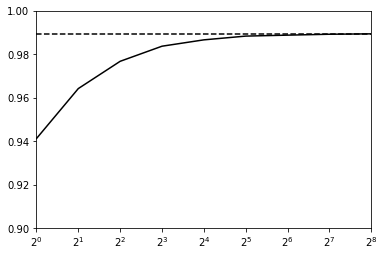

In [236]:
plt.plot([np.min(ntrees), np.max(ntrees)], 
         [np.max(scores), np.max(scores)], 
         'k--')
plt.semilogx(ntrees, scores, 'k-', basex=2)
plt.xlim([min(ntrees), max(ntrees)])
plt.ylim([0.9, 1])

In [ ]:
#forest = tree.DecisionTreeRegressor()
#forest.fit(X, ys)
#forest.oob_score_

In [251]:
forest = ExtraTreesRegressor(n_estimators=256)
#chi2s = [-np.dot(np.dot(y-y_star, Sigma_inv), y-y_star)/2 for idx, y in ys.iterrows()]
#chi2s = [-np.log(np.dot(np.dot(y-y_star, Sigma_inv), y-y_star)/2) for idx, y in ys.iterrows()]
#print(cross_val_score(forest, X, chi2s, cv=3))
#forest.fit(X, chi2s)
#forest.oob_score_

In [257]:
forest = ExtraTreesRegressor(n_estimators=8)
print(cross_val_score(forest, X, ys, cv=3))
forest.fit(X, ys)
#forest.oob_score_

[0.9848735998 0.9845537003 0.9840347758]


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=None,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [187]:
X_max = X.max()
X_min = X.min()

def lnprior(theta):
    if any(theta > X_max) or any(theta < X_min): #X.max()
        return -np.inf
    return 0.0

#def lnprior(theta):
#    if theta.shape == X_max.shape:
#        return _lnprior(theta)
#    return [_lnprior(_theta) for _theta in theta]

def lnlike(theta):
    y = forest.predict([theta])[0]
    resid = y-y_star
    chi2 = np.dot(np.dot(resid, Sigma_inv), resid)
    return -chi2/2
    return(-np.log(chi2)/2)
    #return forest.predict([theta])[0]

#def lnlike(theta):
#    if theta.shape == X_max.shape:
#        return _lnlike(theta)
#    return [_lnlike(_theta) for _theta in theta]

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

In [188]:
theta = [9.9, 0.75408, 0.258478, 0.005, 1.85, -0.0017]

lnprob(theta)

-93.37170585940869

In [189]:
ndim, nwalkers, ntemps = 6, 100, 20
pos = [[10., 0.77, 0.26, 0.005, 1.8, 0.] + 1e-3*np.random.randn(ndim) 
    for i in range(nwalkers)]

pos = np.array(pos)
print(pos.shape)
np.set_printoptions(precision=4, linewidth=100)
pos

(100, 6)


array([[ 9.9992e+00,  7.6938e-01,  2.5795e-01,  5.4139e-03,  1.8023e+00, -7.2262e-04],
       [ 1.0000e+01,  7.6995e-01,  2.5979e-01,  5.4487e-03,  1.8000e+00,  6.4857e-04],
       [ 9.9992e+00,  7.7017e-01,  2.6005e-01,  5.9269e-03,  1.8006e+00, -2.6137e-04],
       [ 9.9988e+00,  7.7208e-01,  2.6049e-01,  4.4266e-03,  1.7995e+00, -4.7392e-04],
       [ 1.0000e+01,  7.6814e-01,  2.5977e-01,  6.3549e-03,  1.8014e+00, -7.8125e-04],
       [ 1.0001e+01,  7.6930e-01,  2.5854e-01,  2.9190e-03,  1.8006e+00,  4.9789e-04],
       [ 1.0001e+01,  7.7101e-01,  2.6088e-01,  4.7857e-03,  1.8017e+00, -5.6748e-04],
       [ 1.0000e+01,  7.7051e-01,  2.6100e-01,  3.2359e-03,  1.7996e+00,  8.3697e-04],
       [ 9.9998e+00,  7.7006e-01,  2.5942e-01,  5.8821e-03,  1.8018e+00, -6.9787e-04],
       [ 1.0001e+01,  7.7109e-01,  2.6043e-01,  6.5569e-03,  1.8000e+00, -6.7515e-04],
       [ 9.9994e+00,  7.7034e-01,  2.5997e-01,  6.5022e-03,  1.7990e+00, -7.0848e-04],
       [ 1.0000e+01,  7.6889e-01,  2.6019e-

In [61]:
#sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
#sampler.run_mcmc(pos, 500)

In [190]:
sampler = emcee.PTSampler(ntemps, nwalkers, ndim, lnlike, lnprior)

#p0 = np.random.uniform(low=-1.0, high=1.0, size=(ntemps, nwalkers, ndim))
p0 = np.array(
    [[[10., 0.77, 0.26, 0.005, 1.8, 0.] + 1e-3*np.random.randn(ndim) 
      for i in range(nwalkers)]
     for j in range(ntemps)])

#p = np.copy(np.array(p0))
#p.reshape((-1, ndim))
#fn = emcee.ptsampler.PTLikePrior(lnlike, lnprior)
#results = list(map(fn, p))

for p, lnp, lnl in sampler.sample(p0, iterations=10):
    pass
sampler.reset()

for p, lnp, lnl in sampler.sample(p, 
        lnprob0=lnp, lnlike0=lnl, iterations=100, thin=1):
    pass

#print(sampler.chain.shape == (ntemps, nwalkers, 1000, ndim))

In [191]:
arr = sampler.chain[...,0]
arr = arr.reshape(-1, arr.shape[-1])
print(arr.shape)
print(arr)

(2000, 100)
[[ 9.9986  9.9972  9.9972 ...  9.9917 10.2311 10.2311]
 [10.0004 10.0031  9.9935 ...  9.9355  9.9126  9.9126]
 [ 9.9916  9.9916 10.0001 ... 10.0915 10.0915 10.0915]
 ...
 [10.0052  9.9994  9.9778 ... 10.4637  9.9974  9.7013]
 [ 9.9732 10.0074 10.0131 ...  9.8688  9.8516  9.6399]
 [ 9.9502 10.0053 10.0004 ...  9.8973  9.9602  9.8453]]


/scratch/seismo/bellinger/python/anaconda3-5.3.0/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


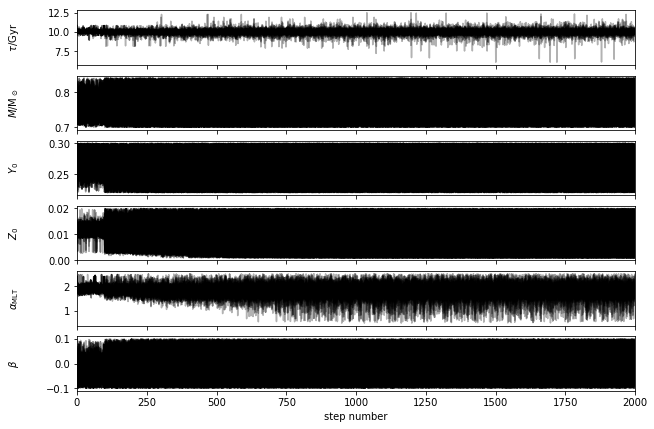

In [225]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.chain #[0,...]
labels = X_labels
for i in range(ndim):
    ax = axes[i]
    arr = sampler.chain[..., i]
    arr = arr.reshape(-1, arr.shape[-1])
    ax.plot(arr, "k", alpha=0.3)
    ax.set_xlim(0, len(arr))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
fig.savefig('chains.pdf')
fig.show()

In [213]:
#samples = sampler.chain[0, :, 50:, :].reshape((-1, ndim))
arr = sampler.chain
arr = arr.reshape(-1, arr.shape[-1])

/scratch/seismo/bellinger/python/anaconda3-5.3.0/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


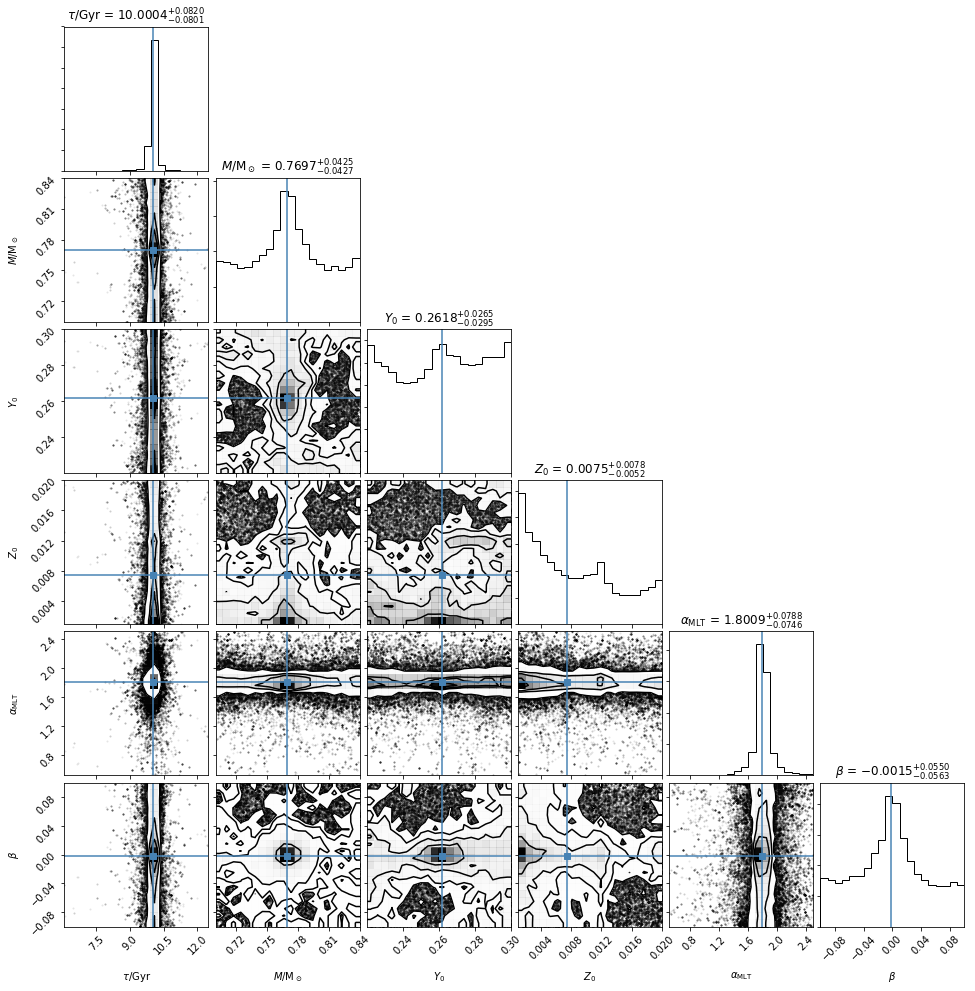

In [223]:
fig = corner.corner(arr, labels=X_labels,
    #quantiles=[0.5],
    show_titles=True,
    title_fmt='.4f',
    #color='b',
    truths=np.percentile(arr, 50, axis=0),
    #truth_color='b',
    title_kwargs={"fontsize": 12})
#fig.savefig('corner.pdf')
fig.show()

In [214]:
#print(samples)
list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
    zip(*np.percentile(arr, [16, 50, 84], axis=0))))

[(10.000402881694853, 0.0820267417620073, 0.0800876098548926),
 (0.7696967304978788, 0.0425387630110492, 0.04265970231516969),
 (0.2618341782609066, 0.026473206887749734, 0.02954151323556689),
 (0.007509047792686735, 0.007832112648193338, 0.005164090297946684),
 (1.8008955161340703, 0.07878680069354305, 0.0745589781362539),
 (-0.0015146501108997436, 0.05498247254820467, 0.05633453332985343)]

In [238]:
0.01 / 13.799e9

7.246901949416624e-13